In [1]:
!pip install scikit-learn


### LOAD DATA FROM IMBD

In [2]:
import tensorflow as tf
import numpy as np

n = 100  
k = 50   
m = 1000
# we load the dataset imdb and we set the train and test data 
(x_train,y_train), (x_test , y_test) = tf.keras.datasets.imdb.load_data(num_words= 4000)
# we make a dictionary that shows the number of every word (ex. the word "this" refers to number 10)
wordIndex = tf.keras.datasets.imdb.get_word_index()

# we reverse the map so that the dictionary shows the words and not the numbers
index2word = dict((i + 3, word) for (word, i) in wordIndex.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test_text = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

### CREATE THE VOCABULARY

In [3]:
from collections import Counter
vocabulary = Counter()
for text in x_train_text:
    tokens = text.split()
    vocabulary.update(tokens)

most_common_words = [word for word, i in vocabulary.most_common(n)]
least_common_words = [word for word, i in vocabulary.most_common()[:-k-1:-1]]

filtered_vocabulary = [word for word in vocabulary.keys() 
                       if word not in most_common_words and word not in least_common_words]

filtered_vocabulary = list(filtered_vocabulary)


### CREATE BINARY VECTOR 

In [4]:
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_classif

def create_binary_vectors(texts, vocabulary):
  binary_vectors = []

  for text in tqdm(texts):
    tokens = text.split()
    b_vector = list()
    for vocab_token in vocabulary:
      if vocab_token in tokens:
        b_vector.append(1)
      else:
        b_vector.append(0)
    binary_vectors.append(b_vector)

  return np.array(binary_vectors)

x_train_binary = create_binary_vectors(x_train_text, filtered_vocabulary)

# πληροφοριακο κερδος
mutual_info = mutual_info_classif(x_train_binary, y_train, discrete_features=True)
# Επιλογή m λέξεων με το υψηλότερο πληροφοριακό κέρδος
top_m_indices = np.argsort(mutual_info)[-m:]
final_vocabulary = [filtered_vocabulary[i] for i in top_m_indices]

# Μετατροπή των δεδομένων σε διανύσματα βάσει του τελικού λεξιλογίου
x_train_binary_final = create_binary_vectors(x_train_text, final_vocabulary)
x_train_binary_final = np.array(x_train_binary_final).reshape(len(x_train_binary_final), -1)
x_test_binary_final = create_binary_vectors(x_test_text, final_vocabulary)
x_test_binary_final = np.array(x_test_binary_final).reshape(len(x_test_binary_final), -1)


100%|██████████| 25000/25000 [01:07<00:00, 371.57it/s]


### Implementing the Random Forest Classification algorithm

In [5]:
class Node :
    def __init__(self , checking_feature = None, isLeaf = False, category = None):
        self.checking_feature = checking_feature
        self.left_child = None
        self.right_child = None
        self.isLeaf = isLeaf
        self.category = category


In [6]:
from statistics import mode
import numpy as np
import math
class ID3 :
    def __init__(self , features):
        self.tree = None
        self.features = features

    def fit(self, x, y) :
        most_common = mode(y.flatten())
        self.tree = self.create_tree(x,y,features = np.arange(len(self.features)) , category = most_common)
        return self.tree 
    
    def create_tree(self,x_train,y_train,features,category) :
        if len(x_train) == 0 :
            return Node(checking_feature= None,isLeaf = True, category = category)
        if np.all(y_train.flatten() ==0) :
            return Node(checking_feature= None , isLeaf= True,category = 0)
        elif np.all(y_train.flatten() == 1) :
            return Node(checking_feature= None, isLeaf = True , category = 1)
        
        if len(features) == 0 :
           return Node(checking_feature= None, isLeaf = True, category = mode(y_train.flatten())) 
        
        igs = list()
        for feat_index in features.flatten() :
            igs.append(self.calculate_ig(y_train.flatten() , [example[feat_index] for example in x_train]))

        max_ig_idx = np.argmax(np.array(igs).flatten())
        common_category = mode(y_train.flatten())

        root = Node(checking_feature= max_ig_idx)

        # data subset with category = 0 
        x_train_0 = x_train[x_train[:, max_ig_idx] == 0, :]
        y_train_0 = y_train[x_train[:,max_ig_idx] == 0].flatten()

        # data subset with category = 1
        x_train_1 = x_train[x_train[:, max_ig_idx] == 1, :]
        y_train_1 = y_train[x_train[:,max_ig_idx] == 1].flatten()

        new_features_indices = np.delete(features.flatten(), max_ig_idx)

        root.left_child = self.create_tree(x_train = x_train_1 , y_train = y_train_1, features = new_features_indices , category = common_category)
        root.right_child = self.create_tree(x_train = x_train_0, y_train = y_train_0, features=new_features_indices,category = common_category)

        return root 

    @staticmethod
    def calculate_ig(classes_vector, feature):
        classes = set(classes_vector)

        HC = 0
        for c in classes:
            PC = list(classes_vector).count(c) / len(classes_vector)  # P(C=c)
            HC += - PC * math.log(PC, 2)  # H(C)
            # print('Overall Entropy:', HC)  # entropy for C variable
            
        feature_values = set(feature)  # 0 or 1 in this example
        HC_feature = 0
        for value in feature_values:
            # pf --> P(X=x)
            pf = list(feature).count(value) / len(feature)  # count occurences of value 
            indices = [i for i in range(len(feature)) if feature[i] == value]  # rows (examples) that have X=x

            classes_of_feat = [classes_vector[i] for i in indices]  # category of examples listed in indices above
            for c in classes:
                # pcf --> P(C=c|X=x)
                pcf = classes_of_feat.count(c) / len(classes_of_feat)  # given X=x, count C
                if pcf != 0: 
                    # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                    temp_H = - pf * pcf * math.log(pcf, 2)
                    # sum for all values of C (class) and X (values of specific feature)
                    HC_feature += temp_H
        
        ig = HC - HC_feature
        return ig    

    def predict(self, x):
        predicted_classes = list()

        for unlabeled in x:  # for every example 
            tmp = self.tree  # begin at root
            while not tmp.isLeaf:
                if unlabeled.flatten()[tmp.checking_feature] == 1:
                    tmp = tmp.left_child
                else:
                    tmp = tmp.right_child
            
            predicted_classes.append(tmp.category)
        
        return np.array(predicted_classes)

In [7]:
import random
# from scipy.stats import mode

class RandomForest:

    def __init__(self, n_trees=15, max_features = None):
        self.n_trees = n_trees
        self.max_features = max_features
        self.trees = []

    #trains the random forest with multiple id3 trees 
    def fit(self, x, y):
        num_samples , num_features = x.shape
        if self.max_features == None :
            self.max_features = int(np.sqrt(num_features))

        for i in range (self.n_trees):
            bootstrap_indices = np.random.choice(range(num_samples), size= num_samples,replace=True)
            x_bootstrap, y_bootstrap = x[bootstrap_indices], y[bootstrap_indices]

            features_indices = np.random.choice(range(num_features), size = self.max_features, replace= False)

            # Train ID3 tree on bootstrap sample with selected features
            tree = ID3(features =features_indices)
            tree.fit(x_bootstrap[:,features_indices], y_bootstrap)
            self.trees.append((tree, features_indices))

    def predict(self,x):

        predictions =[]

        for tree,features_indices in self.trees:
            pred= tree.predict(x[:,features_indices])
            predictions.append(pred)

        predictions = np.array(predictions)
        final_predictions = [mode(predictions[:, i]) for i in range(predictions.shape[1])]
        return np.array(final_predictions)

    

# Training the Random Forest classifier
rf_classifier = RandomForest()
rf_classifier.fit(x_train_binary_final, y_train)

# Testing the classifier
y_pred = rf_classifier.predict(x_train_binary_final)

# Evaluate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")

print("Unique y_test values:", np.unique(y_test))
print("Unique y_pred values:", np.unique(y_pred))


Accuracy: 0.50
Unique y_test values: [0 1]
Unique y_pred values: [0 1]


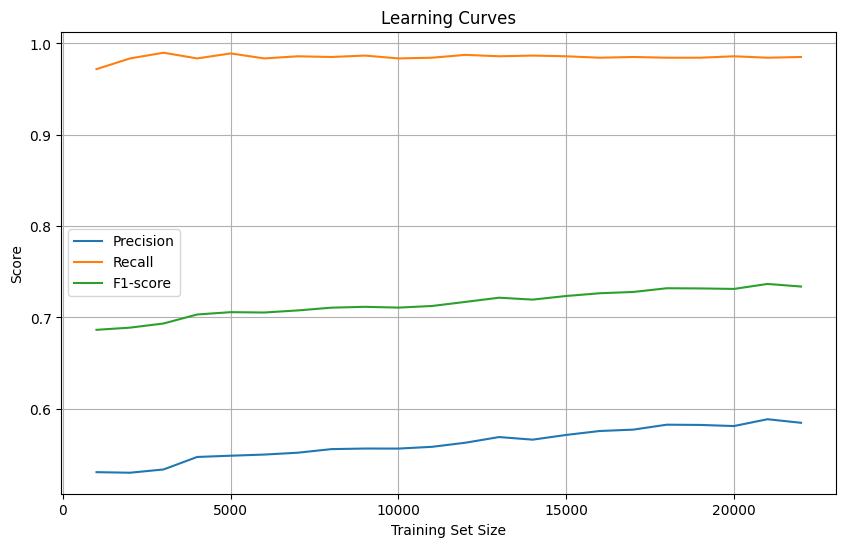

Precision (Positive): 0.5801461919358641
Recall (Positive): 0.98416
F1 (Positive): 0.729980715027444
Precision (Negative): 0.9478260869565217
Recall (Negative): 0.28776
F1 (Negative): 0.44148511813439706
Macro-averaged Precision: 0.7639861394461929
Macro-averaged Recall: 0.6359600000000001
Macro-averaged F1: 0.5857329165809205
Micro-averaged Precision: 0.63596
Micro-averaged Recall: 0.63596
Micro-averaged F1: 0.63596


In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Δημιουργία συνάρτησης για καμπύλες μάθησης
def learning_curves(model, X_train, y_train, X_dev, y_dev, step_size=1000):
    """
    Υπολογισμός καμπυλών μάθησης για διαφορετικά μεγέθη εκπαίδευσης.
    :param model: Το μοντέλο random forest
    :param X_train: Δεδομένα εκπαίδευσης
    :param y_train: Ετικέτες εκπαίδευσης
    :param X_dev: Δεδομένα ανάπτυξης
    :param y_dev: Ετικέτες ανάπτυξης
    :param step_size: Βήμα αύξησης του μεγέθους εκπαίδευσης
    :return: Λίστες με ακρίβεια, ανάκληση, και F1-score
    """
    training_sizes = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(step_size, len(X_train) + 1, step_size):
        # Training subset
        X_subset = X_train[:i]
        y_subset = y_train[:i]

        # Verify alignment of subset
        assert len(X_subset) == len(y_subset), "Mismatch between X_subset and y_subset lengths"

        # Εκπαίδευση του μοντέλου
        model.fit(X_subset, y_subset)

        # Πρόβλεψη στα δεδομένα ανάπτυξης
        y_pred = model.predict(X_dev)

        # Υπολογισμός ακρίβειας, ανάκλησης, και F1
        precision = precision_score(y_dev, y_pred, average='binary')
        recall = recall_score(y_dev, y_pred, average='binary')
        f1 = f1_score(y_dev, y_pred, average='binary')

        # Αποθήκευση αποτελεσμάτων
        training_sizes.append(i)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    return training_sizes, precisions, recalls, f1_scores

# Δημιουργία γραφημάτων
def plot_learning_curves(training_sizes, precisions, recalls, f1_scores):
    plt.figure(figsize=(10, 6))
    plt.plot(training_sizes, precisions, label="Precision")
    plt.plot(training_sizes, recalls, label="Recall")
    plt.plot(training_sizes, f1_scores, label="F1-score")
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid()
    plt.show()

# Εφαρμογή του μοντέλου και υπολογισμός καμπυλών
rf_classifier = RandomForest()

# Δημιουργία δεδομένων ανάπτυξης από τα δεδομένα εκπαίδευσης
dev_size = int(0.1 * len(x_train_binary_final))  # 10% ως development set
X_dev = x_train_binary_final[:dev_size]
y_dev = y_train[:dev_size]

X_train = x_train_binary_final[dev_size:]
y_train = y_train[dev_size:]

# Υπολογισμός καμπυλών μάθησης
training_sizes, precisions, recalls, f1_scores = learning_curves(
    rf_classifier, X_train, y_train, X_dev, y_dev
)

# Σχεδίαση καμπυλών
plot_learning_curves(training_sizes, precisions, recalls, f1_scores)

# Υπολογισμός τελικών αποτελεσμάτων στα δεδομένα αξιολόγησης
rf_classifier.fit(X_train, y_train)
y_test_pred = rf_classifier.predict(x_test_binary_final)

# Ακρίβεια, Ανάκληση και F1 για κατηγορίες και μέσα (macro, micro)
precision_pos = precision_score(y_test, y_test_pred, pos_label=1)
recall_pos = recall_score(y_test, y_test_pred, pos_label=1)
f1_pos = f1_score(y_test, y_test_pred, pos_label=1)

precision_neg = precision_score(y_test, y_test_pred, pos_label=0)
recall_neg = recall_score(y_test, y_test_pred, pos_label=0)
f1_neg = f1_score(y_test, y_test_pred, pos_label=0)

precision_macro = precision_score(y_test, y_test_pred, average="macro")
recall_macro = recall_score(y_test, y_test_pred, average="macro")
f1_macro = f1_score(y_test, y_test_pred, average="macro")

precision_micro = precision_score(y_test, y_test_pred, average="micro")
recall_micro = recall_score(y_test, y_test_pred, average="micro")
f1_micro = f1_score(y_test, y_test_pred, average="micro")

# Εκτύπωση αποτελεσμάτων
print("Precision (Positive):", precision_pos)
print("Recall (Positive):", recall_pos)
print("F1 (Positive):", f1_pos)

print("Precision (Negative):", precision_neg)
print("Recall (Negative):", recall_neg)
print("F1 (Negative):", f1_neg)

print("Macro-averaged Precision:", precision_macro)
print("Macro-averaged Recall:", recall_macro)
print("Macro-averaged F1:", f1_macro)

print("Micro-averaged Precision:", precision_micro)
print("Micro-averaged Recall:", recall_micro)
print("Micro-averaged F1:", f1_micro)